In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.utils import resample

In [2]:
A1 = pd.read_csv('Arrh1.csv')
nist_data = pd.read_csv('Arrh2.csv') #creates dataframes for the Arhenious data and the NIST data

In [16]:
A1['ln_k'] = np.log(A1['k [s-1]'])  
A1['1/T'] = 1 / A1['T [K]']   #creates axis for the graph

x = A1[['1/T']]  
y = A1['ln_k']      
model = LinearRegression().fit(x, y) #creates a model and fits it, allowing for predictions and analysis

gradient = model.coef_[0]
intercept = model.intercept_
y_pred = model.predict(x) #uses the model to make predictions for the Ea and A
A = np.exp(intercept)

R = 8.314 
Ea = -gradient * (R / 1000)  

r2 = r2_score(y, y_pred) #r squared value

A1.describe()


,T [K],k [s-1],ln_k,1/T
count,32.000000,32.000000,32.000000,32.000000
mean,1214.562500,3872.265625,6.454193,0.000845
std,205.048686,5724.680234,2.501437,0.000136
min,950.000000,4.430000,1.488400,0.000605
25%,1027.000000,80.200000,4.371787,0.000717
50%,1195.500000,1400.000000,7.184439,0.000837
75%,1395.500000,5487.500000,8.609036,0.000974
max,1653.000000,23400.000000,10.060491,0.001053


In [5]:
subset = A1[(A1['T [K]'] >= 950) & (A1['T [K]'] <= 1100)] #picks out data at low temp for comparison

x_subset = subset[['1/T']]
y_subset = subset['ln_k']
model_subset = LinearRegression().fit(x_subset, y_subset) #same fitting as above

gradient_subset = model_subset.coef_[0]
intercept_subset = model_subset.intercept_  
y_pred_subset = model_subset.predict(x_subset)
A_subset = np.exp(intercept_subset)
Ea_subset = -gradient_subset * (8.314 / 1000)

r2_subset = r2_score(y_subset, y_pred_subset)

print(f"Full Dataset: Activation Energy (Ea) = {Ea:.2f} kJ/mol, Pre-exponential Factor (A) = {A:.4E}, R-squared = {r2:.3f}") #prints out data to allow for comparison
print(f"Subset Dataset: Activation Energy (Ea) = {Ea_subset:.2f} kJ/mol, Pre-exponential Factor (A) = {A_subset:.4E}, R-squared = {r2_subset:.3f}")

Full Dataset: Activation Energy (Ea) = 148.65 kJ/mol, Pre-exponential Factor (A) = 2.3331E+09, R-squared = 0.950
Subset Dataset: Activation Energy (Ea) = 265.74 kJ/mol, Pre-exponential Factor (A) = 2.0424E+15, R-squared = 0.959


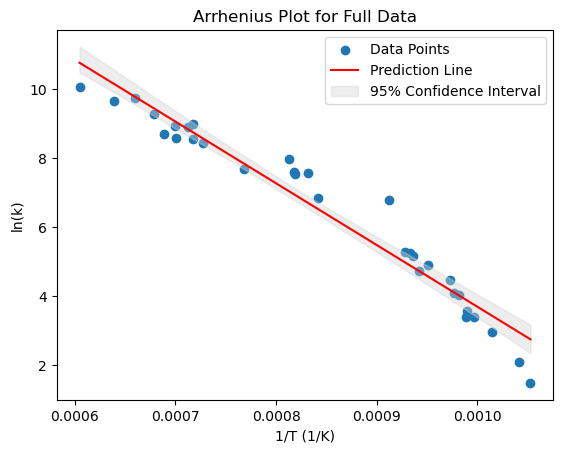

In [6]:
n_iterations = 1000 #amount of iterations of the data to allow for bootstrapping 
preds = [] #empty list of predictions

for i in range(n_iterations):
    x_resample, y_resample = resample(x, y)
    model_bootstrap = LinearRegression().fit(x_resample, y_resample) #models the resampled data  
    preds.append(model_bootstrap.predict(x).flatten()) #adds to teh prediction list

preds = np.array(preds)
lower = np.percentile(preds, 2.5, axis=0) 
upper = np.percentile(preds, 97.5, axis=0) #obtaining the 95% confidence interval

plt.scatter(A1['1/T'], A1['ln_k'], label="Data Points")
plt.plot(A1['1/T'], y_pred, color='red', label='Prediction Line')
plt.fill_between(A1['1/T'], lower, upper, color='lightgrey', alpha=0.4, label="95% Confidence Interval")
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(k)')
plt.legend()
plt.title('Arrhenius Plot for Full Data')
plt.show() #scatter graph containing data plots from dataframe and modelled prediction line, with bootstrapped confidence interval



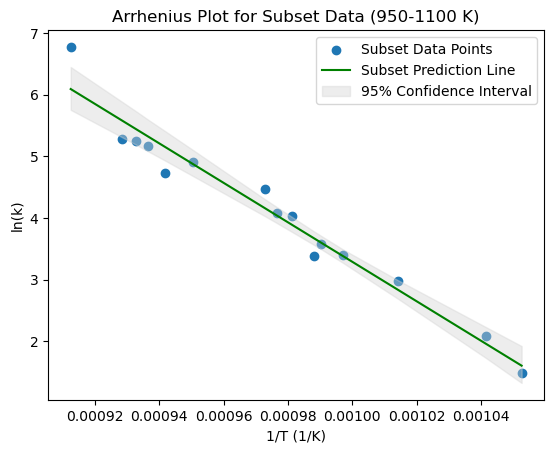

In [7]:
preds_subset = [] #exact same as above but with subset data

for i in range(n_iterations):
    x_resample, y_resample = resample(x_subset, y_subset)
    model_bootstrap_subset = LinearRegression().fit(x_resample, y_resample)
    preds_subset.append(model_bootstrap_subset.predict(x_subset).flatten()) 

preds_subset = np.array(preds_subset)
lower_subset = np.percentile(preds_subset, 2.5, axis=0)  
upper_subset = np.percentile(preds_subset, 97.5, axis=0)  

plt.scatter(x_subset, y_subset, label="Subset Data Points")
plt.plot(x_subset, y_pred_subset, color='green', label='Subset Prediction Line')
plt.fill_between(x_subset.values.flatten(), lower_subset, upper_subset, color='lightgrey', alpha=0.4, label="95% Confidence Interval")
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(k)')
plt.legend()
plt.title('Arrhenius Plot for Subset Data (950-1100 K)')
plt.show()

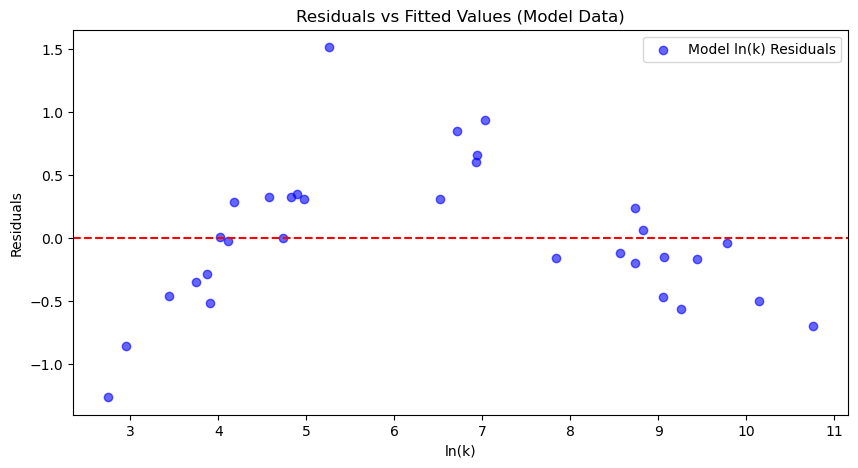

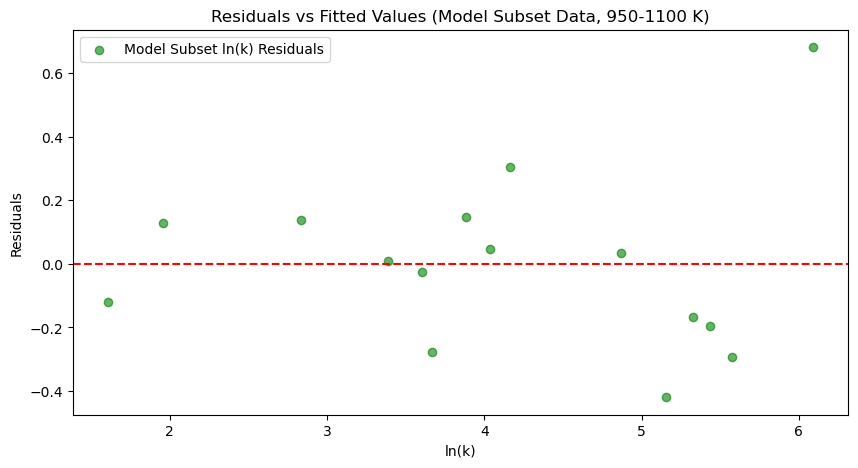

RMSE for Full Dataset: 0.553
RMSE for Subset Dataset: 0.263
Standard Deviation of ln(k) for Model Dataset: 2.501
Standard Deviation of ln(k) for Model Subset Dataset: 1.351


In [8]:
residuals = y - y_pred
residuals_subset = y_subset - y_pred_subset #creates residuals by minusing predicted values from actual values

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6, label='Model ln(k) Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('ln(k)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Model Data)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_subset, residuals_subset, color='green', alpha=0.6, label='Model Subset ln(k) Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('ln(k)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Model Subset Data, 950-1100 K)')
plt.legend()
plt.show()

rmse = np.sqrt(np.mean(residuals ** 2))
rmse_subset = np.sqrt(np.mean(residuals_subset ** 2)) #calculates RMSE values for the full dataset and the subset

print(f"RMSE for Full Dataset: {rmse:.3f}")
print(f"RMSE for Subset Dataset: {rmse_subset:.3f}")

std = y.std()
std_subset = y_subset.std() #calculates standard deviation for the full dataset and subset

print(f"Standard Deviation of ln(k) for Model Dataset: {std:.3f}")
print(f"Standard Deviation of ln(k) for Model Subset Dataset: {std_subset:.3f}")

In [9]:
nist_data[['Temp_min', 'Temp_max']] = nist_data['Temp [K]'].str.split(' - ', expand=True).astype(float)
nist_data['Temp_avg'] = nist_data[['Temp_min', 'Temp_max']].mean(axis=1) #splits the temperature values in the NIST dataframe so that an average can be calculated

nist_subset = nist_data[(nist_data['Temp_avg'] >= 950) & (nist_data['Temp_avg'] <= 1100)] #creates a subset in NIST data similar to above



In [10]:
nist_data_summary = nist_data.describe() #desribes the dataframe values
nist_data_summary 

,A,Ea [kJ/mol],Order,Temp_min,Temp_max,Temp_avg
count,2.700000e+01,27.000000,27.0,27.000000,27.000000,27.000000
mean,1.965081e+15,269.518519,1.0,836.222222,1000.851852,918.537037
std,2.050935e+15,11.470264,0.0,135.209050,224.036862,171.372453
min,3.980000e+11,230.000000,1.0,690.000000,750.000000,720.000000
25%,7.340000e+14,268.500000,1.0,717.000000,800.500000,768.000000
50%,1.580000e+15,272.000000,1.0,773.000000,912.000000,860.500000
75%,2.010000e+15,275.000000,1.0,960.000000,1205.000000,1060.000000
max,8.130000e+15,283.000000,1.0,1100.000000,1450.000000,1275.000000


In [11]:
mean_Ea_nist = nist_data_summary.loc['mean', 'Ea [kJ/mol]']
std_Ea_nist = nist_data_summary.loc['std', 'Ea [kJ/mol]']
std_err_Ea_nist = std_Ea_nist / nist_data_summary.loc['count', 'Ea [kJ/mol]']

mean_A_nist = nist_data_summary.loc['mean', 'A']
std_A_nist = nist_data_summary.loc['std', 'A'] #takes the desired mean and std values for Ea and A
std_err_A_nist = std_A_nist / nist_data_summary.loc['count', 'A']

#std error = std/sqr(pop size)

print(f"The mean Ea for the NIST data is: {mean_Ea_nist:.2f} ± {std_err_Ea_nist:.2f} kJ/mol")
print(f"The mean A for the NIST data is: {mean_A_nist:.4E} ± {std_err_A_nist:.4E}\n") 

Ea_std_dev = math.ceil(abs((Ea - mean_Ea_nist) / std_Ea_nist))
A_std_dev = math.ceil(abs((A - mean_A_nist) / std_A_nist)) #works out how many standard deviations the model data is within and rounds upwards

print(f"The Ea for the model is: {Ea:.2f} kJ/mol, this value is within {Ea_std_dev:.2f} standard deviations from the mean of the NIST data")
print(f"The A for the model is: {A:.4E}, this value is within {A_std_dev:.2f} standard deviations from the mean of the NIST data\n")

Ea_subset_std_dev = math.ceil(abs((Ea_subset - mean_Ea_nist) / std_Ea_nist))
A_subset_std_dev = math.ceil(abs((A_subset - mean_A_nist) / std_A_nist)) #same calc as above but with subset

print(f"The Ea for the subset model is: {Ea_subset:.2f} kJ/mol, this value is within {Ea_subset_std_dev:.2f} standard deviations from the mean of the NIST data of the NIST data")
print(f"The A for the subset model is: {A_subset:.4E}, this value is within {A_subset_std_dev:.2f} standard deviations from the mean")

The mean Ea for the NIST data is: 269.52 ± 0.42 kJ/mol
The mean A for the NIST data is: 1.9651E+15 ± 7.5961E+13

The Ea for the model is: 148.65 kJ/mol, this value is within 11.00 standard deviations from the mean of the NIST data
The A for the model is: 2.3331E+09, this value is within 1.00 standard deviations from the mean of the NIST data

The Ea for the subset model is: 265.74 kJ/mol, this value is within 1.00 standard deviations from the mean of the NIST data of the NIST data
The A for the subset model is: 2.0424E+15, this value is within 1.00 standard deviations from the mean


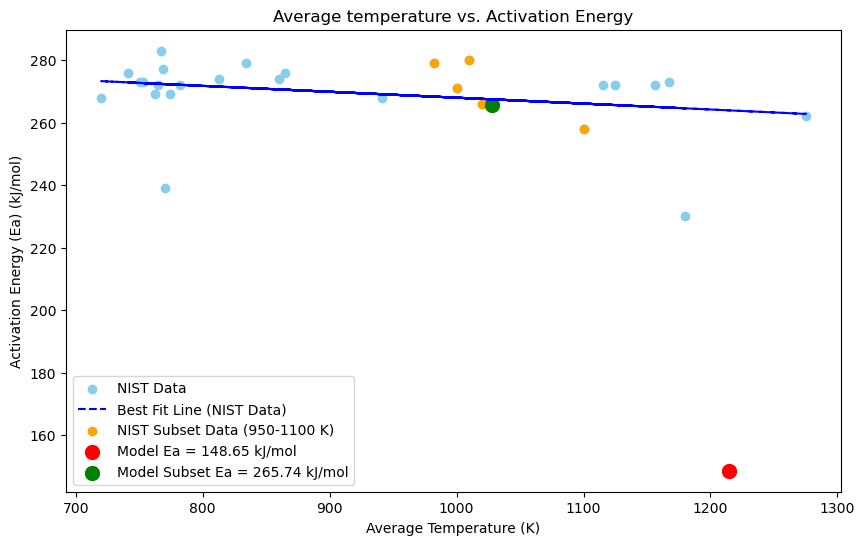

In [12]:
Ea = 148.65
Ea_subset = 265.74

temp_avg_full = nist_data['Temp_avg']
ea_full = nist_data['Ea [kJ/mol]']

temp_avg_subset = nist_subset['Temp_avg']
ea_subset = nist_subset['Ea [kJ/mol]']

avg_temp = A1['T [K]'].mean() 
avg_temp_subset = subset['T [K]'].mean() #takes an average of the temperature in the full dataframe and the subset

x_full = temp_avg_full.values.reshape(-1, 1) #makes a 2D array of the avg temps
y_full = ea_full.values #takes the Ea from the NIST data
model_full = LinearRegression().fit(x_full, y_full) #fits a model for NIST data
y_pred_full = model_full.predict(x_full) #predicts the Ea for teh NIST data

plt.figure(figsize=(10, 6))

plt.scatter(temp_avg_full, ea_full, color='skyblue', label='NIST Data')
plt.plot(temp_avg_full, y_pred_full, color='blue', linestyle='--', label='Best Fit Line (NIST Data)')

plt.scatter(temp_avg_subset, ea_subset, color='orange', label='NIST Subset Data (950-1100 K)')

plt.scatter([avg_temp], Ea, color='red', marker='o', s=100, label=f'Model Ea = {Ea:.2f} kJ/mol') #adds a scatter point for teh full dataset model
plt.scatter([avg_temp_subset], Ea_subset, color='green', marker='o', s=100, label=f'Model Subset Ea = {Ea_subset:.2f} kJ/mol') #adds a scatter point for teh subset dataset model

plt.xlabel('Average Temperature (K)')
plt.ylabel('Activation Energy (Ea) (kJ/mol)')
plt.title('Average temperature vs. Activation Energy')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Activation Energies for full and filtered NIST data')

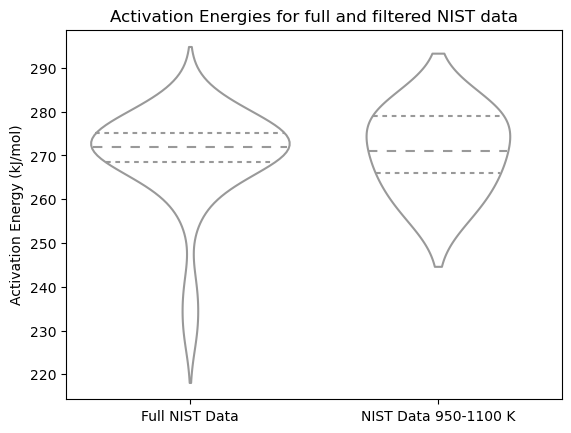

In [19]:
sns.violinplot(data = (ea_full, ea_subset), inner='quartile', color='white')

plt.xticks([0, 1], ['Full NIST Data', 'NIST Data 950-1100 K'])
plt.ylabel('Activation Energy (kJ/mol)')
plt.title('Activation Energies for full and filtered NIST data')

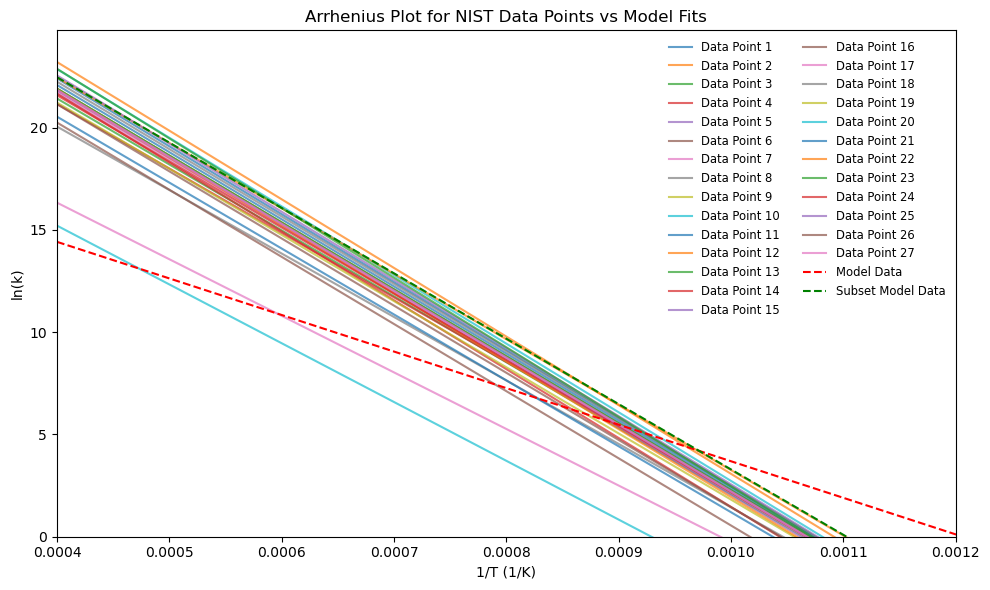

In [13]:
temperatures = np.linspace(2500, 833, 100) 
inverse_T = 1 / temperatures  #creates 100 temp values between 833/2500 K and inverts, to plot against

plt.figure(figsize=(10, 6))

for index, row in nist_data.iterrows(): #for loop to create y=mx + c plots for all data in NIST database to compare against models
    Ea_nist = row['Ea [kJ/mol]'] * 1000  
    ln_A_nist = np.log(row['A'])  
    slope_nist = -Ea_nist / R
    intercept_nist = ln_A_nist
    ln_k_values_nist = slope_nist * inverse_T + intercept_nist
    plt.plot(inverse_T, ln_k_values_nist, label=f'Data Point {index+1}', alpha=0.7)

Ea_full = (Ea) * 1000
Ea_subset = (Ea_subset) * 1000
    
slope_full = -Ea_full / R
intercept_full = np.log(A)
ln_k_values_full = slope_full * inverse_T + intercept_full
plt.plot(inverse_T, ln_k_values_full, 'r--', label="Model Data") #creates y=mx+c graph for the model of the full dataset

slope_subset = -Ea_subset / R
intercept_subset = np.log(A_subset)
ln_k_values_subset = slope_subset * inverse_T + intercept_subset
plt.plot(inverse_T, ln_k_values_subset, 'g--', label="Subset Model Data") #creates y=mx+c graph for the model of the subset

plt.ylim(0, None) #makes sure ln(k) > 0
plt.xlim(0.0004, 0.0012)  #makes the x axis between 0.0004 & 0.0012 1/T, as this range shows all necesarry data

plt.xlabel('1/T (1/K)')
plt.ylabel('ln(k)')
plt.title('Arrhenius Plot for NIST Data Points vs Model Fits')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small', frameon=False) #amended legend so it fits nicely in the top corner
plt.tight_layout()
plt.show()


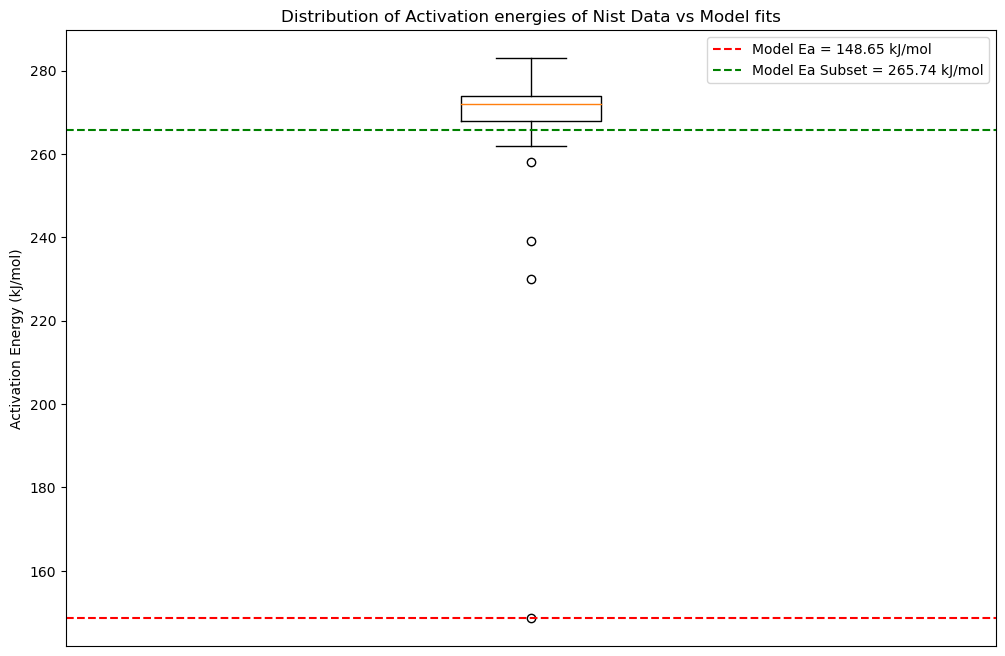

In [14]:
Ea = 148.65
Ea_subset = 265.74
activation_energies = [nist_data['Ea [kJ/mol]'].tolist() + [Ea, Ea_subset]] #puts all nist data & model data in the same dataframe

plt.figure(figsize=(12, 8)) 

plt.boxplot(activation_energies)
plt.gca().set_xticks([])
plt.gca().set_xlabel('') #removes any x axis values
plt.ylabel('Activation Energy (kJ/mol)')

plt.axhline(Ea, color='red', linestyle='--', label=f'Model Ea = {Ea} kJ/mol')
plt.axhline(Ea_subset, color='green', linestyle='--', label=f'Model Ea Subset = {Ea_subset} kJ/mol') #adds lines to highlight where model values lay
plt.title("Distribution of Activation energies of Nist Data vs Model fits")

plt.legend()

plt.show()

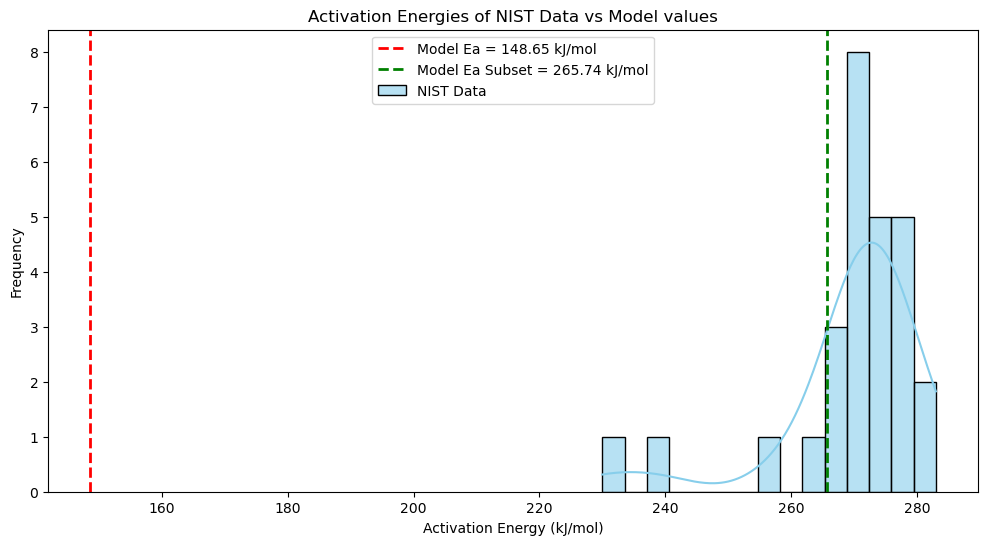

In [15]:
plt.figure(figsize=(12, 6))

sns.histplot(nist_data['Ea [kJ/mol]'], bins=15, kde=True, color='skyblue', label='NIST Data', alpha=0.6)
plt.axvline(Ea, color='red', linestyle='--', linewidth=2, label=f'Model Ea = {Ea:.2f} kJ/mol')
plt.axvline(Ea_subset, color='green', linestyle='--', linewidth=2, label=f'Model Ea Subset = {Ea_subset:.2f} kJ/mol') #same as above, highlight where model values lay

plt.title('Activation Energies of NIST Data vs Model values')
plt.xlabel('Activation Energy (kJ/mol)')
plt.ylabel('Frequency')

plt.legend()
plt.show()
